# P5: Machine Learning on Enron Email Corpus
Ravi Dayabhai

_I hereby confirm that this submission is my work. I have cited above the origins of any parts of the submission that were taken from Websites, books, forums, blog posts, Github repositories, etc. All attribution to sources are cited in the body of this notebook!_

**Assignment questions are top-level sections in the body of this investigation and answered as the analysis below evolves.**

In [1]:
### Import all dependencies
import sys
import pickle
sys.path.append("../tools/")

# Extracting data from pickled data dictionary and splitting on features and labels
from feature_format import featureFormat, targetFeatureSplit

# SKLearn packages
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE, RFECV 
from sklearn.ensemble import RandomForestClassifier

# Imbalanced Learning
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

## Plotting, image creation, visualization
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)

# Decision tree visualization
from sklearn.tree import export_graphviz
import graphviz

# Misc.
import pprint as pp
import warnings
import numpy as np
import pandas as pd
from collections import Counter
import operator

%matplotlib inline
        
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
        
### Making code development; formatting output easier 
pp = pp.PrettyPrinter()
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

//anaconda/envs/DAND/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/envs/DAND/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Below are custom functions and classes I used to assistant in the analysis that follows.

In [2]:
### Testing
def tester(clf, my_dataset, features_list, folds = 1000):
    '''
    Algorithm tester according to test_classifier function in tester.py
    '''
    
    ### Do split(s)
    data = featureFormat(my_dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, 1000, random_state = 42)

    ### Initialize counters for scoring algorithm 
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0

    ### Enter kth-fold loop
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append(features[ii])
            labels_train.append(labels[ii])
        for jj in test_idx:
            features_test.append(features[jj])
            labels_test.append(labels[jj])

        ### Fit and Evaluate algorithm
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"

    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)

        ### Formatting output string
        PERF_FORMAT_STRING = "Accuracy: {:>0.{display_precision}f}\nPrecision: {:>0.{display_precision}f}\
        \nRecall: {:>0.{display_precision}f}\nF1: {:>0.{display_precision}f}\nF2: {:>0.{display_precision}f}"
        RESULTS_FORMAT_STRING = "\nTotal predictions: {:4d}\nTrue positives: {:4d}\nFalse positives: {:4d}\
        \nFalse negatives: {:4d}\nTrue negatives: {:4d}"
        
        ### Output results
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
        
        return accuracy, precision, recall, f1, f2
    
    except:
        print "Got a divide by zero when trying out classifer; check parameters."
        print "Precision or recall may be undefined due to a lack of true positive predicitons."


### Custom feature selector function to split financial and email features
class CustFeatureSelect(BaseEstimator, TransformerMixin):
    """
    Custom feature selector class. It simply returns the feature data split by type of 
    feature based on index specified after manual feature selection.
    """
    def __init__(self, split_idx, front = True):
        self.split_idx = split_idx
        self.front = front

    def fit(self, X, y = None):
        return self

    def transform(self, feature_data):
        if self.front:
            return [sample[:self.split_idx] for sample in feature_data]
        if not self.front:
            return [sample[self.split_idx:] for sample in feature_data]

# Question 1

_Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?_

The primary goal of this project is to build a machine learning classifier that, at the highest level, will be able to receive feature inputs (described below) of a particular person and generate an output that classifies this person as either a "person of interest" or not. A secondary objective is to survey and implement a collection of machine algorithms to this end. 

Machine learning is a useful tool in this exercise because we can leverage "trained" algorithms to find patterns in the data and use said patterns to make predictions. In this context, we are performing _supervised_ learning for a _classification_ task: we have pre-labeled data that can be divided into a "training" and "test" set, the former of which fits the model, and the latter of which validates the model (to ensure that the model we built is generalizable) by taking the training data the model has never encountered and asking it to classify a record into one of two or more categories.

## Background

Our specific data set is of Enron personnel involved in the investigation following the coordinated perpetuation of fraud and epic collapse in the early 2000s. The classification task here is to identify a person as a "POI" or not based on what we know about the features we have on hand (described below).

The pre-canned features included in this data:

**financial features**: `['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']` (all units are in US dollars)

**email features**: `['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']` (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

**POI label**: `[‘poi’]` (boolean, represented as integer)

The email features were extraced from the [Enron email corpus](https://www.cs.cmu.edu/~enron/) and the financial features were extracted from [insider payments published by FindLaw.com](http://news.findlaw.com/hdocs/docs/enron/enron61702insiderpay.pdf). 

## Outlier Removal, Data Wrangling & Exploration

In [3]:
### Remove irrelevant records
for x in ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK']:
    data_dict.pop(x, None)

These records removed don't describe individual persons: the first is simply a sum of all other data fields and the latter is an organization... Interestingly, this [travel agency was run by the sister of Kenneth Lay](http://content.time.com/time/magazine/article/0,9171,198885,00.html)!



Once replacing financial features with `NaN` values with `0`, **what proportion of our records do we have clean data for each feature**?

In [4]:
my_dataset = data_dict

### Features features
financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']
email_features = ['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']
poi_label = ['poi']

# Exploring out-of-box data
counts_my_dataset = {k: 0 for k in financial_features + email_features + poi_label}
all_people = []
no_email_info_list = []

for person, features in my_dataset.iteritems():
    all_people.append(person)
    
    # Replace 'NaN's for financial features
    for fin_feature in financial_features:
        if features[fin_feature] == 'NaN':
            features[fin_feature] = 0
            
    # Count clean data        
    for k, v in features.iteritems():
        try:
            if v != 'NaN':
                counts_my_dataset[k] += 1
            else:
                if person not in no_email_info_list:
                    no_email_info_list.append(person)
        except:
            pass

avail_my_dataset = {k: float(v) / len(my_dataset) for k, v in counts_my_dataset.iteritems()}
pp.pprint(avail_my_dataset)

{'bonus': 1.0,
 'deferral_payments': 1.0,
 'deferred_income': 1.0,
 'director_fees': 1.0,
 'exercised_stock_options': 1.0,
 'expenses': 1.0,
 'from_messages': 0.5972222222222222,
 'from_poi_to_this_person': 0.5972222222222222,
 'from_this_person_to_poi': 0.5972222222222222,
 'loan_advances': 1.0,
 'long_term_incentive': 1.0,
 'other': 1.0,
 'poi': 1.0,
 'restricted_stock': 1.0,
 'restricted_stock_deferred': 1.0,
 'salary': 1.0,
 'shared_receipt_with_poi': 0.5972222222222222,
 'to_messages': 0.5972222222222222,
 'total_payments': 1.0,
 'total_stock_value': 1.0}


**For whom do we have email feature information? For whom do we not?**

In [5]:
print "We DO NOT have emails for {} people.".format(len(no_email_info_list))
pp.pprint(no_email_info_list)

yes_email_info_list = list(set(all_people) - set(no_email_info_list))
print "We DO have emails for {} people.".format(len(yes_email_info_list))
pp.pprint(yes_email_info_list)

We DO NOT have emails for 58 people.
['BAXTER JOHN C',
 'ELLIOTT STEVEN',
 'MORDAUNT KRISTINA M',
 'LOWRY CHARLES P',
 'WESTFAHL RICHARD K',
 'WALTERS GARETH W',
 'CHAN RONNIE',
 'BELFER ROBERT',
 'WODRASKA JOHN',
 'URQUHART JOHN A',
 'WHALEY DAVID A',
 'ECHOLS JOHN B',
 'MENDELSOHN JOHN',
 'CLINE KENNETH W',
 'KOPPER MICHAEL J',
 'BERBERIAN DAVID',
 'DETMERING TIMOTHY J',
 'WAKEHAM JOHN',
 'GOLD JOSEPH',
 'DUNCAN JOHN H',
 'LEMAISTRE CHARLES',
 'KISHKILL JOSEPH G',
 'SULLIVAN-SHAKLOVITZ COLLEEN',
 'WROBEL BRUCE',
 'LINDHOLM TOD A',
 'MEYER JEROME J',
 'BUTTS ROBERT H',
 'CUMBERLAND MICHAEL S',
 'GAHN ROBERT S',
 'HERMANN ROBERT J',
 'SCRIMSHAW MATTHEW',
 'GATHMANN WILLIAM D',
 'GILLIS JOHN',
 'BAZELIDES PHILIP J',
 'FASTOW ANDREW S',
 'LOCKHART EUGENE E',
 'OVERDYKE JR JERE C',
 'PEREIRA PAULO V. FERRAZ',
 'STABLER FRANK',
 'BLAKE JR. NORMAN P',
 'PRENTICE JAMES',
 'GRAY RODNEY',
 'NOLES JAMES L',
 'WHITE JR THOMAS E',
 'CHRISTODOULOU DIOMEDES',
 'JAEDICKE ROBERT',
 'WINOKUR JR. HERBE

**How are POIs distributed between the two groups** (i.e., given availability of email features)?

In [6]:
# Counting POIs
pois_in_yes_email_group = 0
pois_in_no_email_group = 0
total_pois = 0
for person, features in my_dataset.iteritems():

    # Count POIs
    if features['poi'] == 1:
        total_pois += 1
        
        # Assign POIs to group
        if person in yes_email_info_list:
            pois_in_yes_email_group += 1
        else:
            pois_in_no_email_group += 1
    
        
print "TOTAL POIs:", total_pois, "out of", len(my_dataset), "=", total_pois / float(len(my_dataset))
print "'Email info available' POIs:", pois_in_yes_email_group, "out of", len(yes_email_info_list), "=", pois_in_yes_email_group / float(len(yes_email_info_list))
print "'Email info NOT available' POIs:", pois_in_no_email_group, "out of", len(no_email_info_list), "=", pois_in_no_email_group / float(len(no_email_info_list))


TOTAL POIs: 18 out of 144 = 0.125
'Email info available' POIs: 14 out of 86 = 0.162790697674
'Email info NOT available' POIs: 4 out of 58 = 0.0689655172414


This tells us something interesting: conditioning on **having email features available**, the incidence of POIs is **higher** than average, suggesting some slight bias which could manifest itself to a greater degree in a model that relies on email features!

# Question 2

_What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not?_

## Custom Feature Creation

Below, I attempt to implement four custom, composite features based on the following premises:
- I believe that perpetrating fraud requires coordination involving a number of parties that are acting in concert with one another; this leads me to believe that these parties will need to be communicating with other POIs.
    - This suggests that `shared_receipt_with_poi` and/or `from_poi_to_this_person` could come in handy.
    - If a person also _sending_ lots of messages to POIs, that would also suggest coordination (`from_this_person_to_poi` would capture this).
- The individual financial features can sum to a `total_comp` which could reduce noise among the several moving components of any given person's compensation.
- Stock compensation, in particular, might incent management to juice results (read: defraud investors), so determining how important (read: proportion of overall compensation) stock comp was relative to other forms of payment would be important.
    
The following cell shows the calculation of the four custom features I made that address the points raised above:

In [7]:
for person in my_dataset:
    
    ### POI sent incidence
    try:
        my_dataset[person]['poi_sent_incidence'] = my_dataset[person]['from_this_person_to_poi'] / float(my_dataset[person]['from_messages'])
    except:
        my_dataset[person]['poi_sent_incidence'] = 'NaN'
    
    
    ### Direct POI involvement factor
    try:
        my_dataset[person]['dpoif'] = my_dataset[person]['from_poi_to_this_person'] / float(my_dataset[person]['shared_receipt_with_poi'])
    except:
        my_dataset[person]['dpoif'] = 'NaN'
        
    
    ### Total compensation
    try:
        my_dataset[person]['total_comp'] = my_dataset[person]['total_payments'] + float(my_dataset[person]['total_stock_value'])
    except:
        my_dataset[person]['total_comp'] = 'NaN'
    
    
    ### Stock comp proportion
    try:
        my_dataset[person]['stock_comp_proportion'] = my_dataset[person]['total_stock_value'] / float(my_dataset[person]['total_comp'])
    except:
        my_dataset[person]['stock_comp_proportion'] = 'NaN'

Note: `dpoif` (or "direct POI involvement factor") is simply an index that describes the ratio of _direct_ messages a person received from a POI versus all messages received along with POIs.

In [8]:
### Custom features to be included
cust_features = ['poi_sent_incidence', 'dpoif', 'total_comp', 'stock_comp_proportion']
all_features = financial_features + email_features + cust_features
cust_ff = financial_features + ['total_comp', 'stock_comp_proportion']
cust_em = email_features + ['poi_sent_incidence', 'dpoif']

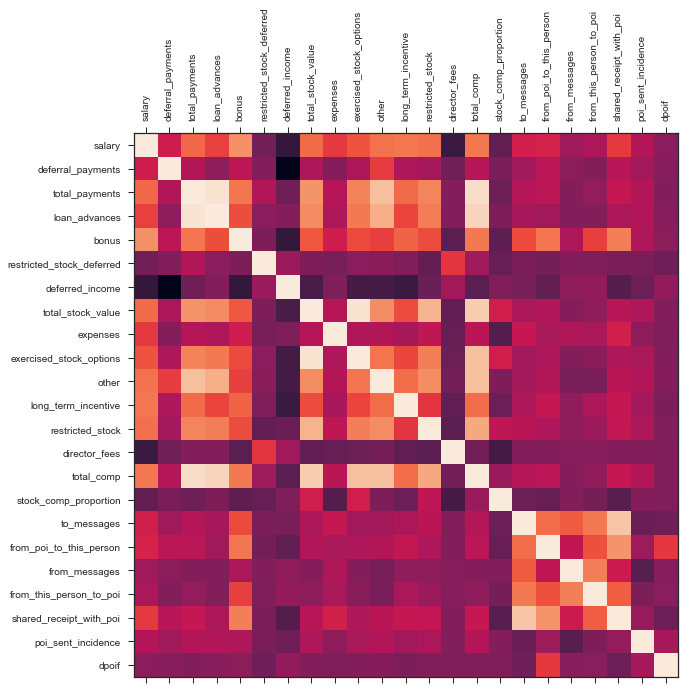

In [9]:
data_table = pd.DataFrame.from_dict(my_dataset, orient = 'index').drop('email_address', axis = 1)
df = data_table.drop('poi', axis = 1).replace(to_replace = 'NaN', value = np.nan)
df = df[cust_ff + cust_em]


### Function to plot correlation matrix
def plot_corr(df, size=10):
    corr = df.corr()
    fig, ax = plt.subplots(figsize = (size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation = 'vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)

### Treat NaNs as averages for purposes of plotting in matrix
for col in df:
    if df[col].isnull().any():
        df[col].fillna(df[col].mean(), inplace=True)
    
### Plot correlation matrix for numerical features
plot_corr(df)



Unfortunately, there isn't an obvious pairwise relationship that stands out between an email feature and a financial feature, (perhaps, with the exception of `bonus` and a handful of email features). That being said, my custom email features seem to not really correlate to any pre-existing feature, which could be promising (read: adding new information).

In [10]:
cols = ["description", "accuracy", "precision", "recall", "f1", "f2"]
perf_df = pd.DataFrame(columns=cols)

Here, I set up a dataframe that will keep track of different performance metrics for different algorithms, tunes, etc.

Note: Scaling was done (as described in the following model implementations) for algorithms that calculate distance (namely, SVMs, PCA). I used MinMax rescaling to normalize values to the interval \[-1,1\].

# Question 4; Classifier Gallery

_What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune?_

Tuning the _hyperparameters_ of a machine algorithm can drastically change affect performance. Tuning is the "[process of maximizing a model's performance without overfitting or creating too high of a variance](https://riskspan.com/news-insight-blog/tuning-machine-learning-models/)."

>**Attribution**: Brooks Anderson in "Tuning Machine Learning Models," RiskSpan.com

These are called _hyper_ parameters that must be set _ex ante_ and not learned by the model during training.

For the models explored below, I primarily employ Grid Search -- essentially a brute force method that takes hyperparameter combinations and picks the best performing combination following multiple cross-validation folds.

I tune various paramters depending on the algorithm selected. See the exploration below for a review of the parameters I ended up tweaking.


## Naive Bayes Classifer

### Feature Selection: Select _k_ Best 

The following implementation achieves project performance thresholds via Naive Bayes with the  "best" (by optimal number and explanatory power) features selected according to ANOVA F-value scoring.

In [11]:
### Data, features import
my_dataset = data_dict
feature_list = poi_label + financial_features + ['total_comp', 'stock_comp_proportion'] + email_features + ['poi_sent_incidence', 'dpoif']

### Do split(s)
data = featureFormat(my_dataset, feature_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
cv = StratifiedShuffleSplit(labels, 20, random_state = 42)

### Set up pipeline
pipe = Pipeline([('kbest', SelectKBest()), 
                ('naive_bayes', GaussianNB())])

### Optimize parameters
params = {'kbest__k': range(2,8)}
grid_search = GridSearchCV(pipe, cv = cv, param_grid = params, scoring = 'f1')
gs_fit = grid_search.fit(features, labels)
print gs_fit.best_params_
clf = gs_fit.best_estimator_
selected_features_args = clf.named_steps['kbest'].get_support(True)
selected_features_scores = clf.named_steps['kbest'].scores_
print "Selected features: ", [feature_list[i+1] for i in selected_features_args]
print "Selected features scores: ", [selected_features_scores[i] for i in selected_features_args]

### Run algorithm; evaluate performance
accuracy, precision, recall, f1, f2 = tester(clf, my_dataset, feature_list)
desc = "NB: KBest"
perf_dict = dict(zip(cols, [desc, accuracy, precision, recall, f1, f2]))
perf_df = perf_df.append(perf_dict, ignore_index=True)
perf_df

//anaconda/envs/DAND/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'kbest__k': 6}
Selected features:  ['salary', 'bonus', 'total_stock_value', 'exercised_stock_options', 'total_comp', 'poi_sent_incidence']
Selected features scores:  [18.289684043404513, 20.792252047181535, 24.18289867856688, 24.815079733218194, 16.99359997135987, 16.40971254803579]
Accuracy: 0.85300
Precision: 0.43314        
Recall: 0.33200
F1: 0.37588
F2: 0.34826

Total predictions: 15000
True positives:  664
False positives:  869        
False negatives: 1336
True negatives: 12131



,description,accuracy,precision,recall,f1,f2
0,NB: KBest,0.853,0.433138,0.332,0.375885,0.348264


This is good performance, but I don't think the redundancy of \[financial\] features is all that helpful in _explaining_ the real-world phenomena being modeled.

[This idea](http://jmlr.csail.mit.edu/papers/volume3/guyon03a/guyon03a.pdf) is explained in the linked paper:

> The papers in this issue focus mainly on constructing and selecting subsets of features that are useful to build a good predictor. This contrasts with the problem of finding or ranking all potentially relevant variables. Selecting the most relevant variables is usually suboptimal for building a predictor, particularly if the variables are redundant. Conversely, a subset of useful variables may exclude many redundant, but relevant, variables. 

In [12]:
### Data, features import
my_dataset = data_dict
feature_list = poi_label + financial_features + ['total_comp', 'stock_comp_proportion'] + email_features + ['poi_sent_incidence', 'dpoif']

### Do split(s)
data = featureFormat(my_dataset, feature_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
cv = StratifiedShuffleSplit(labels, 20, random_state = 42)

### Set up pipeline
pipe = Pipeline([('scaler', MinMaxScaler()), 
                 ('kbest', SelectKBest()), 
                 ('naive_bayes', GaussianNB())])

### Optimize parameters
params = {'kbest__k': range(2,8)}
grid_search = GridSearchCV(pipe, cv = cv, param_grid = params, scoring = 'f1')
gs_fit = grid_search.fit(features, labels)
print gs_fit.best_params_
clf = gs_fit.best_estimator_
selected_features_args = clf.named_steps['kbest'].get_support(True)
selected_features_scores = clf.named_steps['kbest'].scores_
print "Selected features: ", [feature_list[i+1] for i in selected_features_args]
print "Selected features scores: ", [selected_features_scores[i] for i in selected_features_args]

### Run algorithm; evaluate performance
accuracy, precision, recall, f1, f2 = tester(clf, my_dataset, feature_list)
desc = "NB: MinMax, KBest"
perf_dict = dict(zip(cols, [desc, accuracy, precision, recall, f1, f2]))
perf_df = perf_df.append(perf_dict, ignore_index=True)
perf_df

{'kbest__k': 6}
Selected features:  ['salary', 'bonus', 'total_stock_value', 'exercised_stock_options', 'total_comp', 'poi_sent_incidence']
Selected features scores:  [18.289684043404513, 20.792252047181538, 24.182898678566872, 24.815079733218194, 16.99359997135987, 16.40971254803579]
Accuracy: 0.84400
Precision: 0.39130        
Recall: 0.30600
F1: 0.34343
F2: 0.31995

Total predictions: 15000
True positives:  612
False positives:  952        
False negatives: 1388
True negatives: 12048



,description,accuracy,precision,recall,f1,f2
0,NB: KBest,0.853,0.433138,0.332,0.375885,0.348264
1,"NB: MinMax, KBest",0.844,0.391304,0.306,0.343434,0.319950


Interestingly, two of my custom features was included as one of the better features for a more performant algorithm. Also, surprisingly, Naive Bayes performs pretty well "out of box"! Scaling features as a preprocessing setp for Naïve Bayes also seems to reduce performance.

But the financial features that were chosen seem awfully related. Below I plot them to get a feel of how they are related.

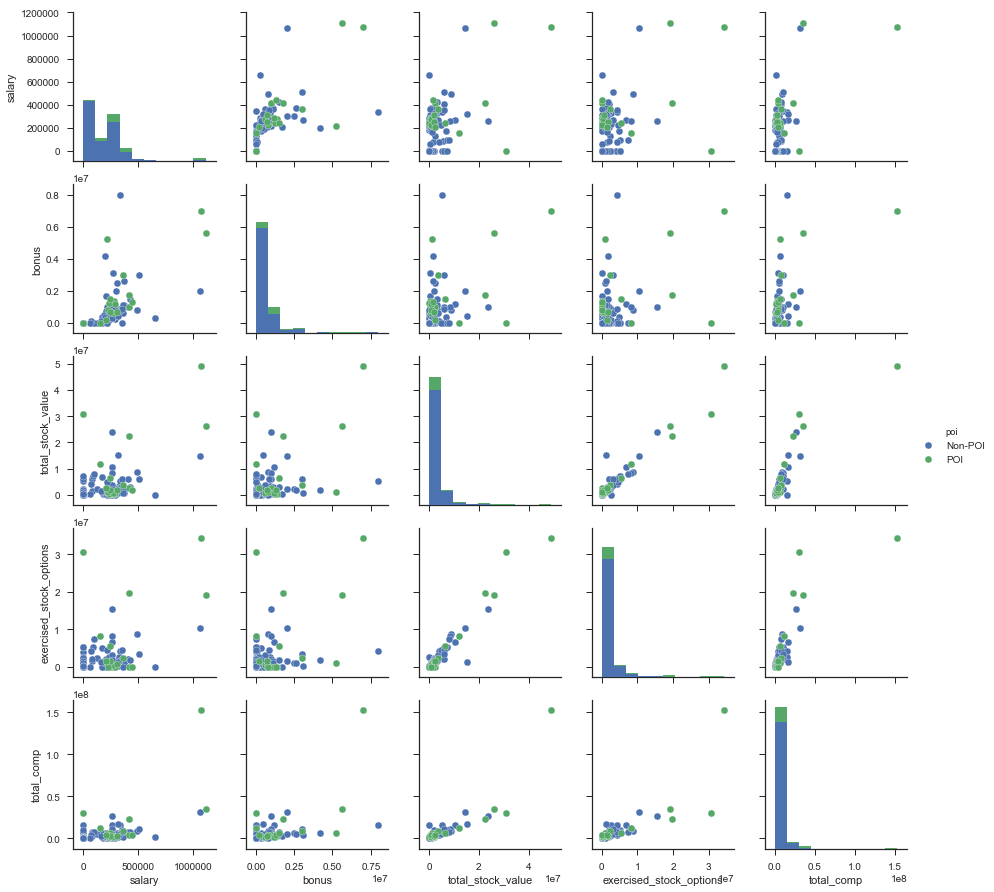

In [13]:
predictors = ['poi', 'salary', 'bonus', 'total_stock_value', 'exercised_stock_options', 'total_comp']
df = pd.DataFrame.from_dict(my_dataset, orient='index')[predictors]
df['poi'] = df['poi'].apply(lambda x: 'POI' if x else 'Non-POI')
sns.pairplot(df, hue = 'poi')

Obviously, the highly correlated features are because some fields (e.g., `total_comp`) are linear combinations of other features (e.g., `salary`, `exercised_stock_options`). Below, I experiment with reducing the feature set and manual feature selection. 

### Dimensionality Reduction + Feature Selection: PCA &rightarrow; Select _k_ Best

That being said, I explore (next) whether the performance of Naive Bayes could be augmented by being smarter about what features I feed into the training process.

The data tends to "overlap" for the two classes (in terms of feature patterns between POIs and non-POIs), which leads me to believe that this is the reason this algorithm might perform better than another which relies on geometric separation (e.g., SVM). Also, two of the selected features (i.e., `total_stock_value` and `exercised_stock_options` are highly linearly correlated), which leads me to believe that some of the fitting is to noise rather than to true markers of data-generating mechanisms.

In [14]:
### Data, features import
my_dataset = data_dict
feature_list = poi_label + all_features

### Do split(s)
data = featureFormat(my_dataset, feature_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
cv = StratifiedShuffleSplit(labels, 20, random_state = 42)

### Set up pipeline
pipe = Pipeline([('scaler', MinMaxScaler()), 
                 ('pca', PCA()), 
                 ('kbest', SelectKBest()),
                 ('naive_bayes', GaussianNB())])

### Optimize parameters; build paramter grid
params = []
max_PCs = 15
for i in range(1, max_PCs+1):
    new_dict = dict(pca__n_components = [i], kbest__k = range(1, i+1))
    params.append(new_dict)

grid_search = GridSearchCV(pipe, cv = cv, param_grid = params, scoring = 'f1')
gs_fit = grid_search.fit(features, labels)
print gs_fit.best_params_
clf = gs_fit.best_estimator_


### Run algorithm; evaluate performance
accuracy, precision, recall, f1, f2 = tester(clf, my_dataset, feature_list)
desc = "NB: PCA -> KBest"
perf_dict = dict(zip(cols, [desc, accuracy, precision, recall, f1, f2]))
perf_df = perf_df.append(perf_dict, ignore_index=True)
perf_df

{'kbest__k': 7, 'pca__n_components': 14}
Accuracy: 0.83173
Precision: 0.36425        
Recall: 0.35150
F1: 0.35776
F2: 0.35398

Total predictions: 15000
True positives:  703
False positives: 1227        
False negatives: 1297
True negatives: 11773



,description,accuracy,precision,recall,f1,f2
0,NB: KBest,0.853000,0.433138,0.3320,0.375885,0.348264
1,"NB: MinMax, KBest",0.844000,0.391304,0.3060,0.343434,0.319950
2,NB: PCA -> KBest,0.831733,0.364249,0.3515,0.357761,0.353978


### Feature Selection: Recursive Feature Elimination (RFE)

Univariate feature selection is a "build up" approach, than recursive feature elimination (RFE) is a "tear down" approach to feature selection. Below, I the logic of the aforementioned processes remains the same, but with RFE employed. First, I look at the out-of-box features; then the outcome following the addition of my custom features.

>**Attribution**: Grace Pehl, a former Udacity student, provided her [custom function](https://github.com/grace-pehl/enron/blob/master/Project/poi_id.py) to perform RFE and it is largely reproduced in this context as she engineered it originally.

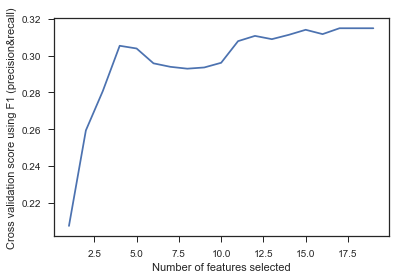

Optimal number of features is 19
Features selected by recursive feature elimination with cross validation:
F1 score from optimal features: 0.315
['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']
Features eliminated:
[] 



In [15]:
def FeatureSelection(data_dict, features_list):                
                
    data = featureFormat(data_dict, features_list, sort_keys = True, remove_all_zeroes = False)
    labels, features = targetFeatureSplit(data)
    sss = StratifiedShuffleSplit(labels, 100, test_size=0.3, random_state=42)
    
    # Create Estimator 
    svc = SVC(kernel='linear', class_weight = 'balanced', random_state=42)
    
    # Scale features for use by SVM
    scaler = MinMaxScaler()
    features = scaler.fit_transform(features)
    
    # Fit RFECV
    rfecv = RFECV(estimator=svc, cv=sss, scoring= 'f1', step=1)
    rfecv = rfecv.fit(features, labels)

    # Plot results
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score using F1 (precision&recall)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    print "Optimal number of features is %d" % rfecv.n_features_
    print 'Features selected by recursive feature elimination with cross validation:'
    F1_score = round(rfecv.grid_scores_[rfecv.n_features_-1], 3)
    print 'F1 score from optimal features: %r' % F1_score
    
    selection = rfecv.get_support()
    selected_features = ['poi']
    rejected_features = []
    for i in range(len(selection)):
        if selection[i]:
            selected_features.append(features_list[i + 1]) # first feature is 'poi'=the label
        else:
            rejected_features.append(features_list[i + 1])

    print selected_features[1:]
    print 'Features eliminated:'
    print rejected_features, "\n"
    
    return selected_features, F1_score

### Data, features import
my_dataset = data_dict
feature_list = poi_label + financial_features + email_features

default_features_RFE, default_features_RFE_f1scores = FeatureSelection(my_dataset, feature_list)

Below, I try to leverage this function to inform another Naïve Bayes implementation:

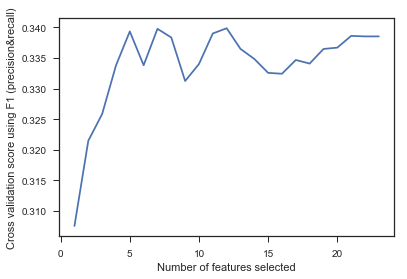

Optimal number of features is 12
Features selected by recursive feature elimination with cross validation:
F1 score from optimal features: 0.34
['salary', 'deferral_payments', 'bonus', 'total_stock_value', 'expenses', 'exercised_stock_options', 'director_fees', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'shared_receipt_with_poi', 'poi_sent_incidence']
Features eliminated:
['total_payments', 'loan_advances', 'restricted_stock_deferred', 'deferred_income', 'other', 'long_term_incentive', 'restricted_stock', 'total_comp', 'stock_comp_proportion', 'from_this_person_to_poi', 'dpoif'] 

{}
Selected features:  ['poi', 'salary', 'deferral_payments', 'bonus', 'total_stock_value', 'expenses', 'exercised_stock_options', 'director_fees', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'shared_receipt_with_poi', 'poi_sent_incidence']
Selected features scores:  0.34
Accuracy: 0.67747
Precision: 0.24172        
Recall: 0.66400
F1: 0.35442
F2: 0.49207

Total predictions: 150

,description,accuracy,precision,recall,f1,f2
0,NB: KBest,0.853000,0.433138,0.3320,0.375885,0.348264
1,"NB: MinMax, KBest",0.844000,0.391304,0.3060,0.343434,0.319950
2,NB: PCA -> KBest,0.831733,0.364249,0.3515,0.357761,0.353978
3,NB: RFECV,0.677467,0.241718,0.6640,0.354417,0.492071


In [16]:
### Data, features import
my_dataset = data_dict
input_feature_list = poi_label + financial_features + ['total_comp', 'stock_comp_proportion'] + email_features + ['poi_sent_incidence', 'dpoif']
feature_list, selected_feature_f1score = FeatureSelection(my_dataset, input_feature_list)

### Do split(s)
data = featureFormat(my_dataset, feature_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
cv = StratifiedShuffleSplit(labels, 20, random_state = 42)

### Set up pipeline
pipe = Pipeline([('naive_bayes', GaussianNB())])

### Optimize parameters
params = {}
grid_search = GridSearchCV(pipe, cv = cv, param_grid = params, scoring = 'f1')
gs_fit = grid_search.fit(features, labels)
print gs_fit.best_params_
clf = gs_fit.best_estimator_
print "Selected features: ", feature_list
print "Selected features scores: ", selected_feature_f1score

### Run algorithm; evaluate performance
accuracy, precision, recall, f1, f2 = tester(clf, my_dataset, feature_list)
desc = "NB: RFECV"
perf_dict = dict(zip(cols, [desc, accuracy, precision, recall, f1, f2]))
perf_df = perf_df.append(perf_dict, ignore_index=True)
perf_df

Accuracy and precision take a drastic hit (relative to earlier Naïve Bayes implementation above), while recall performs much better. This might be a useful tool to play with later as we experiement with different algorithms.

## Support Vector Machine (SVM)

A basic SVM (when tuned with scaled, "best" features) works decently well (see below). 

In [17]:
### Data, features import
my_dataset = data_dict
feature_list = poi_label + financial_features + ['total_comp', 'stock_comp_proportion'] + email_features + ['poi_sent_incidence', 'dpoif']

### Do split(s)
data = featureFormat(my_dataset, feature_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
cv = StratifiedShuffleSplit(labels, 20, random_state = 42)

### Set up pipeline
pipe = Pipeline([('scaler', MinMaxScaler()), 
                 ('kbest', SelectKBest()), 
                 ('svc', SVC())])

### Optimize parameters
params = {'kbest__k': range(2,8), 
          'svc__kernel': ['linear', 'rbf', 'sigmoid'], 
          'svc__gamma': [0.1, 1, 10, 100, 1000], 
          'svc__C': [0.1, 1, 10, 100, 1000]}

grid_search = GridSearchCV(pipe, cv = cv, param_grid = params, scoring = 'f1', verbose = 1, n_jobs = 3)
gs_fit = grid_search.fit(features, labels)
print gs_fit.best_params_
clf = gs_fit.best_estimator_
selected_features_args = clf.named_steps['kbest'].get_support(True)
selected_features_scores = clf.named_steps['kbest'].scores_
print "Selected features: ", [feature_list[i+1] for i in selected_features_args]
print "Selected features scores: ", [selected_features_scores[i] for i in selected_features_args]

### Run algorithm; evaluate performance
accuracy, precision, recall, f1, f2 = tester(clf, my_dataset, feature_list)
desc = "SVM: MinMax, KBest"
perf_dict = dict(zip(cols, [desc, accuracy, precision, recall, f1, f2]))
perf_df = perf_df.append(perf_dict, ignore_index=True)
perf_df

Fitting 20 folds for each of 450 candidates, totalling 9000 fits


[Parallel(n_jobs=3)]: Done 326 tasks      | elapsed:    2.4s
[Parallel(n_jobs=3)]: Done 2030 tasks      | elapsed:   12.4s
[Parallel(n_jobs=3)]: Done 6030 tasks      | elapsed:   34.4s
[Parallel(n_jobs=3)]: Done 9000 out of 9000 | elapsed:   50.3s finished


{'svc__gamma': 100, 'kbest__k': 4, 'svc__kernel': 'rbf', 'svc__C': 100}
Selected features:  ['salary', 'bonus', 'total_stock_value', 'exercised_stock_options']
Selected features scores:  [18.289684043404513, 20.792252047181538, 24.182898678566872, 24.815079733218194]
Accuracy: 0.84273
Precision: 0.35466        
Recall: 0.21900
F1: 0.27079
F2: 0.23714

Total predictions: 15000
True positives:  438
False positives:  797        
False negatives: 1562
True negatives: 12203



,description,accuracy,precision,recall,f1,f2
0,NB: KBest,0.853000,0.433138,0.3320,0.375885,0.348264
1,"NB: MinMax, KBest",0.844000,0.391304,0.3060,0.343434,0.319950
2,NB: PCA -> KBest,0.831733,0.364249,0.3515,0.357761,0.353978
3,NB: RFECV,0.677467,0.241718,0.6640,0.354417,0.492071
4,"SVM: MinMax, KBest",0.842733,0.354656,0.2190,0.270788,0.237141


It seems that this model is overly-reliant on the best financial features. A result of fitting on these features is that precision is pretty high, but recalls suffers considerably (vs. Naive Bayes). Next, I try to increase the overall F1 score by balancing recall with precision (without losing any/much accuracy); to achieve this, I try to:

1. Use RFE to perform feature selection rather than SelectKBest
2. Preserve features (rather than SelectKBest, which throws features out) and use dimensionality reduction to help simplify and (hopefully) make more salient a decision boundary via SVM.

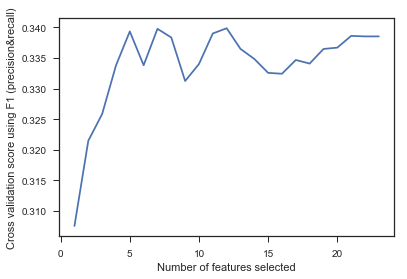

Optimal number of features is 12
Features selected by recursive feature elimination with cross validation:
F1 score from optimal features: 0.34
['salary', 'deferral_payments', 'bonus', 'total_stock_value', 'expenses', 'exercised_stock_options', 'director_fees', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'shared_receipt_with_poi', 'poi_sent_incidence']
Features eliminated:
['total_payments', 'loan_advances', 'restricted_stock_deferred', 'deferred_income', 'other', 'long_term_incentive', 'restricted_stock', 'total_comp', 'stock_comp_proportion', 'from_this_person_to_poi', 'dpoif'] 

{'svc__gamma': 1, 'svc__kernel': 'rbf', 'svc__C': 100}
Selected features:  ['poi', 'salary', 'deferral_payments', 'bonus', 'total_stock_value', 'expenses', 'exercised_stock_options', 'director_fees', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'shared_receipt_with_poi', 'poi_sent_incidence']
Selected features scores:  0.34
Accuracy: 0.82460
Precision: 0.28639        
Recall: 0.2

,description,accuracy,precision,recall,f1,f2
0,NB: KBest,0.853000,0.433138,0.3320,0.375885,0.348264
1,"NB: MinMax, KBest",0.844000,0.391304,0.3060,0.343434,0.319950
2,NB: PCA -> KBest,0.831733,0.364249,0.3515,0.357761,0.353978
3,NB: RFECV,0.677467,0.241718,0.6640,0.354417,0.492071
4,"SVM: MinMax, KBest",0.842733,0.354656,0.2190,0.270788,0.237141
5,"SVM: MinMax, RFECV",0.824600,0.286391,0.2115,0.243313,0.223172


In [18]:
### Data, features import
my_dataset = data_dict
input_feature_list = poi_label + financial_features + ['total_comp', 'stock_comp_proportion'] + email_features + ['poi_sent_incidence', 'dpoif']
feature_list, selected_feature_f1score = FeatureSelection(my_dataset, input_feature_list)

### Do split(s)
data = featureFormat(my_dataset, feature_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
cv = StratifiedShuffleSplit(labels, 20, random_state = 42)

### Set up pipeline
pipe = Pipeline([('scaler', MinMaxScaler()), 
                 ('svc', SVC())])

### Optimize parameters
params = {'svc__kernel': ['linear', 'rbf', 'sigmoid'], 
          'svc__gamma': [0.1, 1, 10, 100, 1000], 
          'svc__C': [0.1, 1, 10, 100, 1000]}

grid_search = GridSearchCV(pipe, cv = cv, param_grid = params, scoring = 'f1')
gs_fit = grid_search.fit(features, labels)
print gs_fit.best_params_
clf = gs_fit.best_estimator_
print "Selected features: ", feature_list
print "Selected features scores: ", selected_feature_f1score

### Run algorithm; evaluate performance
accuracy, precision, recall, f1, f2 = tester(clf, my_dataset, feature_list)
desc = "SVM: MinMax, RFECV"
perf_dict = dict(zip(cols, [desc, accuracy, precision, recall, f1, f2]))
perf_df = perf_df.append(perf_dict, ignore_index=True)
perf_df

### Dimensionality Reduction: PCA

Some of the fields in the data are somewhat correlated because they are literally functions of one another (e.g., `total_stock_value` is the sum of `exercised_stock_options` and `restricted_stock` and `restricted_stock_deferred`). The _k_ best feature selection run above also suggests that there might be a latent "big shot" feature of some sort appearing in our data. 

The following implementation is, for the most part, the same as above, but employing PCA to all features.

In [19]:
### Data, features import
my_dataset = data_dict
feature_list = poi_label + financial_features + ['total_comp', 'stock_comp_proportion'] + email_features + ['poi_sent_incidence', 'dpoif']

### Do split(s)
data = featureFormat(my_dataset, feature_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
cv = StratifiedShuffleSplit(labels, 20, random_state = 42)

### Set up pipeline
pipe = Pipeline([('scaler', MinMaxScaler()), 
                 ('pca', PCA()),  
                 ('svc', SVC())])

### Optimize parameterse
params = {'pca__n_components': range(1,4), 
          'svc__kernel': ['linear', 'sigmoid', 'rbf'], 
          'svc__gamma': [0.1, 1, 10, 100, 1000], 
          'svc__C': [0.1, 1, 10, 100, 1000]}

grid_search = GridSearchCV(pipe, cv = cv, param_grid = params, scoring = 'f1', verbose = 1, n_jobs = 3)
gs_fit = grid_search.fit(features, labels)
print gs_fit.best_params_, "\n"
clf = gs_fit.best_estimator_

### Run algorithm; evaluate performance
accuracy, precision, recall, f1, f2 = tester(clf, my_dataset, feature_list)
desc = "SVM: MinMax, PCA"
perf_dict = dict(zip(cols, [desc, accuracy, precision, recall, f1, f2]))
perf_df = perf_df.append(perf_dict, ignore_index=True)
perf_df

Fitting 20 folds for each of 225 candidates, totalling 4500 fits


[Parallel(n_jobs=3)]: Done 158 tasks      | elapsed:    2.5s
[Parallel(n_jobs=3)]: Done 758 tasks      | elapsed:   10.5s
[Parallel(n_jobs=3)]: Done 1758 tasks      | elapsed:   24.9s
[Parallel(n_jobs=3)]: Done 3158 tasks      | elapsed:   45.2s
[Parallel(n_jobs=3)]: Done 4500 out of 4500 | elapsed:  1.1min finished


{'svc__gamma': 1, 'pca__n_components': 2, 'svc__kernel': 'sigmoid', 'svc__C': 100} 

Accuracy: 0.83247
Precision: 0.34668        
Recall: 0.29000
F1: 0.31582
F2: 0.29980

Total predictions: 15000
True positives:  580
False positives: 1093        
False negatives: 1420
True negatives: 11907



,description,accuracy,precision,recall,f1,f2
0,NB: KBest,0.853000,0.433138,0.3320,0.375885,0.348264
1,"NB: MinMax, KBest",0.844000,0.391304,0.3060,0.343434,0.319950
2,NB: PCA -> KBest,0.831733,0.364249,0.3515,0.357761,0.353978
3,NB: RFECV,0.677467,0.241718,0.6640,0.354417,0.492071
4,"SVM: MinMax, KBest",0.842733,0.354656,0.2190,0.270788,0.237141
5,"SVM: MinMax, RFECV",0.824600,0.286391,0.2115,0.243313,0.223172
6,"SVM: MinMax, PCA",0.832467,0.346683,0.2900,0.315818,0.299804


We see an overall performance improvement (when measuring by F1 score, but _not_ by accuracy) when simplifying our higher-dimensional data into a handful of principal components (after removing the "totals" features). We've also learned that there isn't one or two principal components driving the majority of variation seen in our data.

In [20]:
print "Explained variance ratio:", clf.named_steps['pca'].explained_variance_ratio_

z = 0
for pc in clf.named_steps['pca'].components_:
    print "\nPC {}:".format(z+1)
    pp.pprint(pc)
    contribution_pc = np.multiply(pc, pc) / pc.dot(pc)
    print "\nContribution to PC {} length:\n".format(z+1), contribution_pc
    print "\n"
    sorted_feature_idx = np.argsort(np.multiply(pc, pc) / pc.dot(pc))
    for i in sorted_feature_idx[::-1]:
        print feature_list[i+1], "\t", contribution_pc[i]
    z += 1

Explained variance ratio: [0.28278415 0.15114892]

PC 1:
array([ 0.33667683,  0.12451199,  0.26425042,  0.09429346,  0.27248825,
       -0.01602511, -0.20075168,  0.22945445,  0.15093899,  0.17059095,
        0.12310916,  0.15424748,  0.21869177, -0.2557494 ,  0.33437964,
        0.027271  ,  0.23116793,  0.24060429,  0.06902368,  0.14969136,
        0.36378123,  0.14393656,  0.12959196])

Contribution to PC 1 length:
[0.11335129 0.01550323 0.06982829 0.00889126 0.07424985 0.0002568
 0.04030124 0.05264935 0.02278258 0.02910127 0.01515587 0.02379229
 0.04782609 0.06540776 0.11180974 0.00074371 0.05343861 0.05789043
 0.00476427 0.0224075  0.13233678 0.02071773 0.01679408]


shared_receipt_with_poi 	0.1323367830666887
salary 	0.1133512863565833
total_comp 	0.11180974280236422
bonus 	0.07424984908580022
total_payments 	0.06982828587039644
director_fees 	0.06540775582706164
from_poi_to_this_person 	0.05789042642333871
to_messages 	0.053438610130655616
total_stock_value 	0.05264934585990535


The relationships among financial features suggest some sort of latent feature of employees (e.g., in the same way "size" is a latent feature for a house); this might be something along the lines of "powered (or levered) incentives" which were regarded post-Enron as the fuel for the fire:

>\[options...\] encouraging corporate managers to push accounting rules "to the limit," in order to make their financial statement look better, so their stock prices will go up, "so that executives can cash in their options."

> [WSJ, 2002. "Stock Options Come Under Fire in the Wake of Enron's Collapse."](https://www.wsj.com/articles/SB1017093594617163160)

### PCA: 'Piecewise' Application

**Hypothesis**: The underlying theory behind the application of PCA to this problem hinges on the idea that POIs are likely individuals who had a lot to gain through stock or related compensation (manifest in financial features) and who were working together to make this happen (manifest in email features).

Below I attempt to do a 'manual' PCA procedure, building on the exploration above, for each feature type (i.e., email or financial) that then gets consumed by a SVM.




In [21]:
### Data, features import
my_dataset = data_dict
feature_list = poi_label + financial_features + ['total_comp', 'stock_comp_proportion'] + email_features + ['poi_sent_incidence', 'dpoif']

# List of features included
feature_list_ = feature_list[1:]

### Do split(s)
data = featureFormat(my_dataset, feature_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Cross Validation
cv = StratifiedShuffleSplit(labels, 10, random_state = 42)

### Set up pipeline
pipeline = Pipeline([

    # Use FeatureUnion to combine the financial and email features
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for transforming financial features
            ('ff', Pipeline([
                ('selector', CustFeatureSelect(14, front = True)),
                ('scaler', MinMaxScaler()),
                ('pca', PCA()),
            ])),

            # Pipeline for transforming email features
            ('em', Pipeline([
                ('selector', CustFeatureSelect(14, front = False)),
                ('scaler', MinMaxScaler()),
                ('pca', PCA()),
            ]))
        ],
        
        # Weight components in FeatureUnion
        transformer_weights={
            'ff': 0.7,
            'em': 0.3
        },
    )),

    # Use a SVC classifier on the combined features
    ('svc', SVC())
    
])

### Optimize parameters
params = {'union__ff__pca__n_components': range(1,4), 
          'union__em__pca__n_components': range(1,4),
          'svc__kernel': ['linear', 'rbf', 'sigmoid'], 
          'svc__gamma': [0.1, 1, 10, 100, 1000], 
          'svc__C': [0.1, 1, 10, 100, 1000]}

grid_search = GridSearchCV(pipeline, cv = cv, param_grid = params, scoring = 'f1', verbose = 1, n_jobs = 3)
gs_fit = grid_search.fit(features, labels)
print gs_fit.best_params_
clf = gs_fit.best_estimator_

### Run algorithm; evaluate performance
accuracy, precision, recall, f1, f2 = tester(clf, my_dataset, feature_list)
desc = "SVM: 'Piecewise' PCA"
perf_dict = dict(zip(cols, [desc, accuracy, precision, recall, f1, f2]))
perf_df = perf_df.append(perf_dict, ignore_index=True)
perf_df

Fitting 10 folds for each of 675 candidates, totalling 6750 fits


[Parallel(n_jobs=3)]: Done 158 tasks      | elapsed:    4.2s
[Parallel(n_jobs=3)]: Done 758 tasks      | elapsed:   17.5s
[Parallel(n_jobs=3)]: Done 1758 tasks      | elapsed:   39.9s
[Parallel(n_jobs=3)]: Done 3158 tasks      | elapsed:  1.2min
[Parallel(n_jobs=3)]: Done 4958 tasks      | elapsed:  1.8min
[Parallel(n_jobs=3)]: Done 6750 out of 6750 | elapsed:  2.5min finished


{'union__ff__pca__n_components': 2, 'svc__gamma': 10, 'svc__kernel': 'sigmoid', 'svc__C': 1, 'union__em__pca__n_components': 1}
Accuracy: 0.88100
Precision: 0.83912        
Recall: 0.13300
F1: 0.22961
F2: 0.15991

Total predictions: 15000
True positives:  266
False positives:   51        
False negatives: 1734
True negatives: 12949



,description,accuracy,precision,recall,f1,f2
0,NB: KBest,0.853000,0.433138,0.3320,0.375885,0.348264
1,"NB: MinMax, KBest",0.844000,0.391304,0.3060,0.343434,0.319950
2,NB: PCA -> KBest,0.831733,0.364249,0.3515,0.357761,0.353978
3,NB: RFECV,0.677467,0.241718,0.6640,0.354417,0.492071
4,"SVM: MinMax, KBest",0.842733,0.354656,0.2190,0.270788,0.237141
5,"SVM: MinMax, RFECV",0.824600,0.286391,0.2115,0.243313,0.223172
6,"SVM: MinMax, PCA",0.832467,0.346683,0.2900,0.315818,0.299804
7,SVM: 'Piecewise' PCA,0.881000,0.839117,0.1330,0.229607,0.159913


In [22]:
### Data, features import
my_dataset = data_dict
feature_list = poi_label + financial_features + ['total_comp', 'stock_comp_proportion'] + email_features + ['poi_sent_incidence', 'dpoif']

### Remove somewhat redundant features
# feature_list.remove('total_payments')
# feature_list.remove('total_stock_value')

# List of features included
feature_list_ = feature_list[1:]

### Do split(s)
data = featureFormat(my_dataset, feature_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Cross Validation
cv = StratifiedShuffleSplit(labels, 10, random_state = 42)

### Set up pipeline
pipeline = Pipeline([

    # Use FeatureUnion to combine the financial and email features
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for transforming financial features
            ('ff', Pipeline([
                ('selector', CustFeatureSelect(14, front = True)),
                ('scaler', MinMaxScaler()),
                ('pca', PCA()),
            ])),

            # Pipeline for transforming email features
            ('em', Pipeline([
                ('selector', CustFeatureSelect(14, front = False)),
                ('scaler', MinMaxScaler()),
                ('pca', PCA()),
            ]))
        ],
        
        # Weight components in FeatureUnion
        transformer_weights={
            'ff': 0.7,
            'em': 0.3
        },
    )),

    # Use a SVC classifier on the combined features
    ('svc', SVC(class_weight = 'balanced'))
    
])

### Optimize parameters
params = {'union__ff__pca__n_components': range(1,4), 
          'union__em__pca__n_components': range(1,4),
          'svc__kernel': ['linear', 'rbf', 'sigmoid'], 
          'svc__gamma': [0.1, 1, 10, 100, 1000], 
          'svc__C': [0.1, 1, 10, 100, 1000]}

grid_search = GridSearchCV(pipeline, cv = cv, param_grid = params, scoring = 'f1', verbose = 1, n_jobs = 3)
gs_fit = grid_search.fit(features, labels)
print gs_fit.best_params_
clf = gs_fit.best_estimator_

### Run algorithm; evaluate performance
accuracy, precision, recall, f1, f2 = tester(clf, my_dataset, feature_list)
desc = "SVM: 'Piecewise' PCA, Class Weight"
perf_dict = dict(zip(cols, [desc, accuracy, precision, recall, f1, f2]))
perf_df = perf_df.append(perf_dict, ignore_index=True)
perf_df

Fitting 10 folds for each of 675 candidates, totalling 6750 fits


[Parallel(n_jobs=3)]: Done 158 tasks      | elapsed:    4.0s
[Parallel(n_jobs=3)]: Done 758 tasks      | elapsed:   16.7s
[Parallel(n_jobs=3)]: Done 1758 tasks      | elapsed:   38.0s
[Parallel(n_jobs=3)]: Done 3158 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 4958 tasks      | elapsed:  1.8min
[Parallel(n_jobs=3)]: Done 6750 out of 6750 | elapsed:  2.4min finished


{'union__ff__pca__n_components': 1, 'svc__gamma': 1, 'svc__kernel': 'sigmoid', 'svc__C': 1000, 'union__em__pca__n_components': 3}
Accuracy: 0.74947
Precision: 0.30958        
Recall: 0.71450
F1: 0.43198
F2: 0.56634

Total predictions: 15000
True positives: 1429
False positives: 3187        
False negatives:  571
True negatives: 9813



,description,accuracy,precision,recall,f1,f2
0,NB: KBest,0.853000,0.433138,0.3320,0.375885,0.348264
1,"NB: MinMax, KBest",0.844000,0.391304,0.3060,0.343434,0.319950
2,NB: PCA -> KBest,0.831733,0.364249,0.3515,0.357761,0.353978
3,NB: RFECV,0.677467,0.241718,0.6640,0.354417,0.492071
4,"SVM: MinMax, KBest",0.842733,0.354656,0.2190,0.270788,0.237141
5,"SVM: MinMax, RFECV",0.824600,0.286391,0.2115,0.243313,0.223172
6,"SVM: MinMax, PCA",0.832467,0.346683,0.2900,0.315818,0.299804
7,SVM: 'Piecewise' PCA,0.881000,0.839117,0.1330,0.229607,0.159913
8,"SVM: 'Piecewise' PCA, Class Weight",0.749467,0.309575,0.7145,0.431983,0.566344


I see that accuracy suffers when `class_weight = 'balanced'`, which in effect, penalizes the model more for incorrect classification of the more infrequent class.

## Decision Tree

First, I set up a basic decision tree.

In [23]:
### Data, features import
my_dataset = data_dict
feature_list = poi_label + financial_features + ['total_comp', 'stock_comp_proportion'] + email_features + ['poi_sent_incidence', 'dpoif']

### Do split(s)
data = featureFormat(my_dataset, feature_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
cv = StratifiedShuffleSplit(labels, 20, random_state = 42)

### Set up pipeline
pipe = Pipeline([('scaler', MinMaxScaler()), 
                 ('kbest', SelectKBest()), 
                 ('dtc', DecisionTreeClassifier())])

### Optimize parameters
params = {'kbest__k': range(2,8), 
          'dtc__min_samples_split': range(3,11), 
          'dtc__max_depth': range(2,11)}

grid_search = GridSearchCV(pipe, cv = cv, param_grid = params, scoring = 'f1', verbose = 1, n_jobs = 3)
gs_fit = grid_search.fit(features, labels)
print gs_fit.best_params_
clf = gs_fit.best_estimator_
selected_features_args = clf.named_steps['kbest'].get_support(True)
selected_features_scores = clf.named_steps['kbest'].scores_
print "Selected features: ", [feature_list[i+1] for i in selected_features_args]
print "Selected features scores: ", [selected_features_scores[i] for i in selected_features_args]

### Run algorithm; evaluate performance
accuracy, precision, recall, f1, f2 = tester(clf, my_dataset, feature_list)
desc = "DT: MinMax, KBest"
perf_dict = dict(zip(cols, [desc, accuracy, precision, recall, f1, f2]))
perf_df = perf_df.append(perf_dict, ignore_index=True)
perf_df

Fitting 20 folds for each of 432 candidates, totalling 8640 fits


[Parallel(n_jobs=3)]: Done 278 tasks      | elapsed:    2.1s
[Parallel(n_jobs=3)]: Done 1478 tasks      | elapsed:    9.4s
[Parallel(n_jobs=3)]: Done 3478 tasks      | elapsed:   21.8s
[Parallel(n_jobs=3)]: Done 6278 tasks      | elapsed:   39.2s
[Parallel(n_jobs=3)]: Done 8640 out of 8640 | elapsed:   53.5s finished


{'dtc__min_samples_split': 3, 'dtc__max_depth': 6, 'kbest__k': 3}
Selected features:  ['bonus', 'total_stock_value', 'exercised_stock_options']
Selected features scores:  [20.792252047181538, 24.182898678566872, 24.815079733218194]
Accuracy: 0.82267
Precision: 0.30263        
Recall: 0.25300
F1: 0.27560
F2: 0.26158

Total predictions: 15000
True positives:  506
False positives: 1166        
False negatives: 1494
True negatives: 11834



,description,accuracy,precision,recall,f1,f2
0,NB: KBest,0.853000,0.433138,0.3320,0.375885,0.348264
1,"NB: MinMax, KBest",0.844000,0.391304,0.3060,0.343434,0.319950
2,NB: PCA -> KBest,0.831733,0.364249,0.3515,0.357761,0.353978
3,NB: RFECV,0.677467,0.241718,0.6640,0.354417,0.492071
4,"SVM: MinMax, KBest",0.842733,0.354656,0.2190,0.270788,0.237141
5,"SVM: MinMax, RFECV",0.824600,0.286391,0.2115,0.243313,0.223172
6,"SVM: MinMax, PCA",0.832467,0.346683,0.2900,0.315818,0.299804
7,SVM: 'Piecewise' PCA,0.881000,0.839117,0.1330,0.229607,0.159913
8,"SVM: 'Piecewise' PCA, Class Weight",0.749467,0.309575,0.7145,0.431983,0.566344
9,"DT: MinMax, KBest",0.822667,0.302632,0.2530,0.275599,0.261580


After getting a basic decision tree up and running, I play with the `class_weight` parameter and others.

In [24]:
### Data, features import
my_dataset = data_dict
feature_list = poi_label + financial_features + ['total_comp', 'stock_comp_proportion'] + email_features + ['poi_sent_incidence', 'dpoif']

### Remove somewhat redundant features
# feature_list.remove('total_payments')
# feature_list.remove('total_stock_value')

### Do split(s)
data = featureFormat(my_dataset, feature_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
cv = StratifiedShuffleSplit(labels, 20, random_state = 42)

### Set up pipeline
pipe = Pipeline([('scaler', MinMaxScaler()), 
                 ('kbest', SelectKBest()), 
                 ('dtc', DecisionTreeClassifier(class_weight = 'balanced'))])

### Optimize parameters
params = {'kbest__k': range(2,8), 
          'dtc__min_samples_split': range(3,11), 
          'dtc__max_depth': range(2,11), 
          'dtc__criterion': ['entropy', 'gini']}

grid_search = GridSearchCV(pipe, cv = cv, param_grid = params, scoring = 'f1', verbose = 1, n_jobs = 3)
gs_fit = grid_search.fit(features, labels)
print gs_fit.best_params_
clf = gs_fit.best_estimator_
selected_features_args = clf.named_steps['kbest'].get_support(True)
selected_features_scores = clf.named_steps['kbest'].scores_
print "Selected features: ", [feature_list[i+1] for i in selected_features_args]
print "Selected features scores: ", [selected_features_scores[i] for i in selected_features_args]

### Run algorithm; evaluate performance
accuracy, precision, recall, f1, f2 = tester(clf, my_dataset, feature_list)
desc = "DT: MinMax, KBest, Criterion, Class Weight"
perf_dict = dict(zip(cols, [desc, accuracy, precision, recall, f1, f2]))
perf_df = perf_df.append(perf_dict, ignore_index=True)
perf_df

Fitting 20 folds for each of 864 candidates, totalling 17280 fits


[Parallel(n_jobs=3)]: Done 286 tasks      | elapsed:    2.1s
[Parallel(n_jobs=3)]: Done 1486 tasks      | elapsed:    9.7s
[Parallel(n_jobs=3)]: Done 3486 tasks      | elapsed:   22.2s
[Parallel(n_jobs=3)]: Done 6286 tasks      | elapsed:   39.7s
[Parallel(n_jobs=3)]: Done 9886 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 14286 tasks      | elapsed:  1.5min
[Parallel(n_jobs=3)]: Done 17280 out of 17280 | elapsed:  1.8min finished


{'dtc__criterion': 'gini', 'dtc__max_depth': 3, 'kbest__k': 6, 'dtc__min_samples_split': 4}
Selected features:  ['salary', 'bonus', 'total_stock_value', 'exercised_stock_options', 'total_comp', 'poi_sent_incidence']
Selected features scores:  [18.289684043404513, 20.792252047181538, 24.182898678566872, 24.815079733218194, 16.99359997135987, 16.40971254803579]
Accuracy: 0.78600
Precision: 0.32575        
Recall: 0.56550
F1: 0.41338
F2: 0.49294

Total predictions: 15000
True positives: 1131
False positives: 2341        
False negatives:  869
True negatives: 10659



,description,accuracy,precision,recall,f1,f2
0,NB: KBest,0.853000,0.433138,0.3320,0.375885,0.348264
1,"NB: MinMax, KBest",0.844000,0.391304,0.3060,0.343434,0.319950
2,NB: PCA -> KBest,0.831733,0.364249,0.3515,0.357761,0.353978
3,NB: RFECV,0.677467,0.241718,0.6640,0.354417,0.492071
4,"SVM: MinMax, KBest",0.842733,0.354656,0.2190,0.270788,0.237141
5,"SVM: MinMax, RFECV",0.824600,0.286391,0.2115,0.243313,0.223172
6,"SVM: MinMax, PCA",0.832467,0.346683,0.2900,0.315818,0.299804
7,SVM: 'Piecewise' PCA,0.881000,0.839117,0.1330,0.229607,0.159913
8,"SVM: 'Piecewise' PCA, Class Weight",0.749467,0.309575,0.7145,0.431983,0.566344
9,"DT: MinMax, KBest",0.822667,0.302632,0.2530,0.275599,0.261580


I am checking, visually, to see what a decision tree is doing with with a small number of features (based on intuition garnered from running the prior algorithms and time spent with this data) having a sense of which features are most important.

Fitting 50 folds for each of 162 candidates, totalling 8100 fits


[Parallel(n_jobs=3)]: Done 518 tasks      | elapsed:    2.4s
[Parallel(n_jobs=3)]: Done 2918 tasks      | elapsed:   11.4s
[Parallel(n_jobs=3)]: Done 6918 tasks      | elapsed:   26.4s
[Parallel(n_jobs=3)]: Done 8100 out of 8100 | elapsed:   30.6s finished


{'dtc__criterion': 'entropy', 'dtc__max_depth': 2, 'dtc__min_samples_split': 2}
Feature Importances:
{'poi_sent_incidence': 0.5089046231646969,
 'shared_receipt_with_poi': 0.2974231656779193,
 'total_stock_value': 0.1936722111573838}


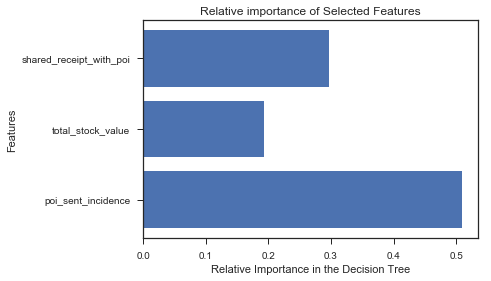

Accuracy: 0.85264
Precision: 0.48723        
Recall: 0.60100
F1: 0.53817
F2: 0.57419

Total predictions: 14000
True positives: 1202
False positives: 1265        
False negatives:  798
True negatives: 10735



,description,accuracy,precision,recall,f1,f2
0,NB: KBest,0.853000,0.433138,0.3320,0.375885,0.348264
1,"NB: MinMax, KBest",0.844000,0.391304,0.3060,0.343434,0.319950
2,NB: PCA -> KBest,0.831733,0.364249,0.3515,0.357761,0.353978
3,NB: RFECV,0.677467,0.241718,0.6640,0.354417,0.492071
4,"SVM: MinMax, KBest",0.842733,0.354656,0.2190,0.270788,0.237141
5,"SVM: MinMax, RFECV",0.824600,0.286391,0.2115,0.243313,0.223172
6,"SVM: MinMax, PCA",0.832467,0.346683,0.2900,0.315818,0.299804
7,SVM: 'Piecewise' PCA,0.881000,0.839117,0.1330,0.229607,0.159913
8,"SVM: 'Piecewise' PCA, Class Weight",0.749467,0.309575,0.7145,0.431983,0.566344
9,"DT: MinMax, KBest",0.822667,0.302632,0.2530,0.275599,0.261580


In [25]:
### Data, features import
my_dataset = data_dict
feature_list = poi_label + ['poi_sent_incidence', 'total_stock_value', 'shared_receipt_with_poi'] 

### Do split(s)
data = featureFormat(my_dataset, feature_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
cv = StratifiedShuffleSplit(labels, 50, random_state = 42)

### Set up pipeline
pipe = Pipeline([('dtc', DecisionTreeClassifier(presort = True))])

### Optimize parameters
params = {'dtc__min_samples_split': range(2,11), 
          'dtc__max_depth': range(2,11), 
          'dtc__criterion': ['entropy', 'gini']}

grid_search = GridSearchCV(pipe, cv = cv, param_grid = params, scoring = 'f1', verbose = 1, n_jobs = 3)
gs_fit = grid_search.fit(features, labels)
print gs_fit.best_params_
clf = gs_fit.best_estimator_

### Visualize decision tree; intermediate file
dtree = clf.named_steps['dtc']
export_graphviz(dtree, out_file="mytree.dot")

### Get feature importance
feature_importances = clf.named_steps['dtc'].feature_importances_
feature_importances_dict = dict(zip(feature_list[1:], feature_importances))
print "Feature Importances:"
pp.pprint(feature_importances_dict)

### Plot feature importance
plt.barh(range(len(feature_list[1:])), feature_importances, align='center')
plt.yticks(range(len(feature_list[1:])), feature_list[1:])
plt.xlabel('Relative Importance in the Decision Tree')
plt.ylabel('Features')
plt.title('Relative importance of Selected Features')
plt.show()

### Run algorithm; evaluate performance
accuracy, precision, recall, f1, f2 = tester(clf, my_dataset, feature_list)
desc = "DT: Custom Feature Selection, Criterion"
perf_dict = dict(zip(cols, [desc, accuracy, precision, recall, f1, f2]))
perf_df = perf_df.append(perf_dict, ignore_index=True)
perf_df

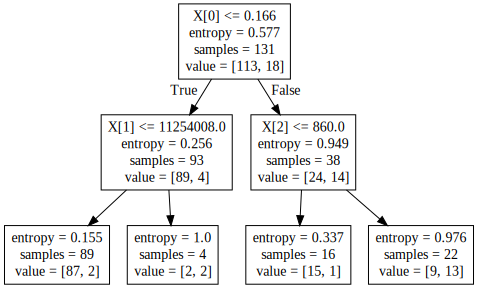

In [26]:
with open("mytree.dot") as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)

This was a remarkable discovery (i.e., feature selection based on intuition improved performance so much), but I can't help but feel that some of this is [due to "leakage" of information](https://discussions.udacity.com/t/mistake-in-the-way-email-poi-features-are-engineered-in-the-course/4841/3?u=per48edjes) between testing and training, especially for the email features included here. This is still pretty surprising to me, that such a weak (`max_depth = 2`) classifier performs so well.

### "Oversampling" POIs

Below I try rudimentary "oversampling" from my dataset to see if the class imbalance is causing poor classifier performance.

In [27]:
### Data, features import
feature_list = poi_label + financial_features + ['total_comp', 'stock_comp_proportion'] + email_features + ['poi_sent_incidence', 'dpoif']

### Do split(s) [and training] on OVERSAMPLED data set
data = featureFormat(my_dataset, feature_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Creating oversampled data set using Imblanced Learning
ros = RandomOverSampler('minority', random_state = 42)
features_ros, labels_ros = ros.fit_sample(features, labels)
cv = StratifiedShuffleSplit(labels_ros, 20, random_state = 42)

## Set up pipeline
pipe = Pipeline([('scaler', MinMaxScaler()), 
                 ('kbest', SelectKBest()), 
                 ('dtc', DecisionTreeClassifier())])

### Optimize parameters
params = {'kbest__k': range(2,8), 
          'dtc__min_samples_split': range(3,11), 
          'dtc__max_depth': range(2,11)}

grid_search = GridSearchCV(pipe, cv = cv, param_grid = params, scoring = 'f1', verbose = 1, n_jobs = 3)
gs_fit = grid_search.fit(features_ros, labels_ros)
print gs_fit.best_params_
clf = gs_fit.best_estimator_
selected_features_args = clf.named_steps['kbest'].get_support(True)
selected_features_scores = clf.named_steps['kbest'].scores_
print "Selected features: ", [feature_list[i+1] for i in selected_features_args]
print "Selected features scores: ", [selected_features_scores[i] for i in selected_features_args]

### Run algorithm; evaluate performance
accuracy, precision, recall, f1, f2 = tester(clf, my_dataset, feature_list)
desc = "Random Oversampled DT: MinMax, KBest"
perf_dict = dict(zip(cols, [desc, accuracy, precision, recall, f1, f2]))
perf_df = perf_df.append(perf_dict, ignore_index=True)
perf_df

Fitting 20 folds for each of 432 candidates, totalling 8640 fits


[Parallel(n_jobs=3)]: Done 386 tasks      | elapsed:    2.0s
[Parallel(n_jobs=3)]: Done 3006 tasks      | elapsed:   13.3s
[Parallel(n_jobs=3)]: Done 8006 tasks      | elapsed:   34.5s
[Parallel(n_jobs=3)]: Done 8640 out of 8640 | elapsed:   36.8s finished


{'dtc__min_samples_split': 5, 'dtc__max_depth': 9, 'kbest__k': 6}
Selected features:  ['salary', 'bonus', 'deferred_income', 'expenses', 'shared_receipt_with_poi', 'poi_sent_incidence']
Selected features scores:  [44.09608427329071, 37.38358024778996, 26.07447765220295, 28.420100753199396, 22.82320547781693, 55.23250717306667]
Accuracy: 0.79893
Precision: 0.22361        
Recall: 0.20550
F1: 0.21417
F2: 0.20888

Total predictions: 15000
True positives:  411
False positives: 1427        
False negatives: 1589
True negatives: 11573



,description,accuracy,precision,recall,f1,f2
0,NB: KBest,0.853000,0.433138,0.3320,0.375885,0.348264
1,"NB: MinMax, KBest",0.844000,0.391304,0.3060,0.343434,0.319950
2,NB: PCA -> KBest,0.831733,0.364249,0.3515,0.357761,0.353978
3,NB: RFECV,0.677467,0.241718,0.6640,0.354417,0.492071
4,"SVM: MinMax, KBest",0.842733,0.354656,0.2190,0.270788,0.237141
5,"SVM: MinMax, RFECV",0.824600,0.286391,0.2115,0.243313,0.223172
6,"SVM: MinMax, PCA",0.832467,0.346683,0.2900,0.315818,0.299804
7,SVM: 'Piecewise' PCA,0.881000,0.839117,0.1330,0.229607,0.159913
8,"SVM: 'Piecewise' PCA, Class Weight",0.749467,0.309575,0.7145,0.431983,0.566344
9,"DT: MinMax, KBest",0.822667,0.302632,0.2530,0.275599,0.261580


The random sampling technique delivered generally pretty poor results, so below I employ a SMOTE oversampling technique.

In [28]:
### Data, features import
feature_list = poi_label + financial_features + ['total_comp', 'stock_comp_proportion'] + email_features + ['poi_sent_incidence', 'dpoif']

### Do split(s) [and training] on OVERSAMPLED data set
data = featureFormat(my_dataset, feature_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Creating oversampled data set using Imblanced Learning
smote = SMOTE(ratio = 0.5, k = 5, random_state = 42)
features_smote, labels_smote = smote.fit_sample(features, labels)
cv = StratifiedShuffleSplit(labels_smote, 20, random_state = 42)

## Set up pipeline
pipe = Pipeline([('scaler', MinMaxScaler()), 
                 ('kbest', SelectKBest()), 
                 ('dtc', DecisionTreeClassifier())])

### Optimize parameters
params = {'kbest__k': range(2,8), 
          'dtc__min_samples_split': range(3,11), 
          'dtc__max_depth': range(2,11)}

grid_search = GridSearchCV(pipe, cv = cv, param_grid = params, scoring = 'f1', verbose = 1, n_jobs = 3)
gs_fit = grid_search.fit(features_smote, labels_smote)
print gs_fit.best_params_
clf = gs_fit.best_estimator_
selected_features_args = clf.named_steps['kbest'].get_support(True)
selected_features_scores = clf.named_steps['kbest'].scores_
print "Selected features: ", [feature_list[i+1] for i in selected_features_args]
print "Selected features scores: ", [selected_features_scores[i] for i in selected_features_args]


### Run algorithm; evaluate performance
accuracy, precision, recall, f1, f2 = tester(clf, my_dataset, feature_list)
desc = "SMOTE DT: MinMax, KBest"
perf_dict = dict(zip(cols, [desc, accuracy, precision, recall, f1, f2]))
perf_df = perf_df.append(perf_dict, ignore_index=True)
perf_df

Fitting 20 folds for each of 432 candidates, totalling 8640 fits


//anaconda/envs/DAND/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
//anaconda/envs/DAND/lib/python2.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
[Parallel(n_jobs=3)]: Done 806 tasks      | elapsed:    3.7s
[Parallel(n_jobs=3)]: Done 3806 tasks      | elapsed:   16.1s
[Parallel(n_jobs=3)]: Done 8640 out of 8640 | elapsed:   36.0s finished


{'dtc__min_samples_split': 3, 'dtc__max_depth': 2, 'kbest__k': 7}
Selected features:  ['salary', 'bonus', 'total_stock_value', 'expenses', 'exercised_stock_options', 'shared_receipt_with_poi', 'poi_sent_incidence']
Selected features scores:  [40.75933192567589, 37.39005204121652, 25.368965642806632, 30.266874168402797, 23.420596837654514, 23.347799628869684, 41.03264374943257]
Accuracy: 0.83687
Precision: 0.27401        
Recall: 0.13550
F1: 0.18133
F2: 0.15074

Total predictions: 15000
True positives:  271
False positives:  718        
False negatives: 1729
True negatives: 12282



,description,accuracy,precision,recall,f1,f2
0,NB: KBest,0.853000,0.433138,0.3320,0.375885,0.348264
1,"NB: MinMax, KBest",0.844000,0.391304,0.3060,0.343434,0.319950
2,NB: PCA -> KBest,0.831733,0.364249,0.3515,0.357761,0.353978
3,NB: RFECV,0.677467,0.241718,0.6640,0.354417,0.492071
4,"SVM: MinMax, KBest",0.842733,0.354656,0.2190,0.270788,0.237141
5,"SVM: MinMax, RFECV",0.824600,0.286391,0.2115,0.243313,0.223172
6,"SVM: MinMax, PCA",0.832467,0.346683,0.2900,0.315818,0.299804
7,SVM: 'Piecewise' PCA,0.881000,0.839117,0.1330,0.229607,0.159913
8,"SVM: 'Piecewise' PCA, Class Weight",0.749467,0.309575,0.7145,0.431983,0.566344
9,"DT: MinMax, KBest",0.822667,0.302632,0.2530,0.275599,0.261580


### "Undersampling" Non-POIs
I try undersampling using the basic decision tree:

In [29]:
### Data, features import
feature_list = poi_label + financial_features + ['total_comp', 'stock_comp_proportion'] + email_features + ['poi_sent_incidence', 'dpoif']

### Do split(s) [and training] on UNDERSAMPLED data set
data = featureFormat(my_dataset, feature_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Creating oversampled data set using Imblanced Learning
rus = RandomUnderSampler(ratio = 0.5, random_state = 42)
features_rus, labels_rus = rus.fit_sample(features, labels)
cv = StratifiedShuffleSplit(labels_rus, 20, random_state = 42)

## Set up pipeline
pipe = Pipeline([('scaler', MinMaxScaler()), 
                 ('kbest', SelectKBest()), 
                 ('dtc', DecisionTreeClassifier())])

### Optimize parameters
params = {'kbest__k': range(2,8), 
          'dtc__min_samples_split': range(3,11), 
          'dtc__max_depth': range(2,11)}

grid_search = GridSearchCV(pipe, cv = cv, param_grid = params, scoring = 'f1', verbose = 1, n_jobs = 3)
gs_fit = grid_search.fit(features_rus, labels_rus)
print gs_fit.best_params_
clf = gs_fit.best_estimator_
selected_features_args = clf.named_steps['kbest'].get_support(True)
selected_features_scores = clf.named_steps['kbest'].scores_
print "Selected features: ", [feature_list[i+1] for i in selected_features_args]
print "Selected features scores: ", [selected_features_scores[i] for i in selected_features_args]


### Run algorithm; evaluate performance
accuracy, precision, recall, f1, f2 = tester(clf, my_dataset, feature_list)
desc = "Random Undersampling DT: MinMax, KBest"
perf_dict = dict(zip(cols, [desc, accuracy, precision, recall, f1, f2]))
perf_df = perf_df.append(perf_dict, ignore_index=True)
perf_df

Fitting 20 folds for each of 432 candidates, totalling 8640 fits


//anaconda/envs/DAND/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
[Parallel(n_jobs=3)]: Done 462 tasks      | elapsed:    2.1s
[Parallel(n_jobs=3)]: Done 2262 tasks      | elapsed:    9.8s
[Parallel(n_jobs=3)]: Done 5262 tasks      | elapsed:   22.8s
[Parallel(n_jobs=3)]: Done 8640 out of 8640 | elapsed:   37.0s finished


{'dtc__min_samples_split': 10, 'dtc__max_depth': 10, 'kbest__k': 7}
Selected features:  ['salary', 'bonus', 'total_stock_value', 'exercised_stock_options', 'long_term_incentive', 'from_poi_to_this_person', 'poi_sent_incidence']
Selected features scores:  [9.448660586539813, 10.339019735299043, 7.4346622152235975, 6.71992179317707, 11.570852689331362, 7.623348593591014, 11.901139678842906]
Accuracy: 0.81367
Precision: 0.23693        
Recall: 0.17900
F1: 0.20393
F2: 0.18820

Total predictions: 15000
True positives:  358
False positives: 1153        
False negatives: 1642
True negatives: 11847



,description,accuracy,precision,recall,f1,f2
0,NB: KBest,0.853000,0.433138,0.3320,0.375885,0.348264
1,"NB: MinMax, KBest",0.844000,0.391304,0.3060,0.343434,0.319950
2,NB: PCA -> KBest,0.831733,0.364249,0.3515,0.357761,0.353978
3,NB: RFECV,0.677467,0.241718,0.6640,0.354417,0.492071
4,"SVM: MinMax, KBest",0.842733,0.354656,0.2190,0.270788,0.237141
5,"SVM: MinMax, RFECV",0.824600,0.286391,0.2115,0.243313,0.223172
6,"SVM: MinMax, PCA",0.832467,0.346683,0.2900,0.315818,0.299804
7,SVM: 'Piecewise' PCA,0.881000,0.839117,0.1330,0.229607,0.159913
8,"SVM: 'Piecewise' PCA, Class Weight",0.749467,0.309575,0.7145,0.431983,0.566344
9,"DT: MinMax, KBest",0.822667,0.302632,0.2530,0.275599,0.261580


## Random Forest

Thus far, it looks like the over- and undersampling techniques I've employed have really struggled to make my algorithms more performant. I explore "bagging" (i.e., *b*ootstrap *agg*regat*ing*) in the context of Decision Trees by implementing a Random Forest classifier below.

Fitting 20 folds for each of 57 candidates, totalling 1140 fits


//anaconda/envs/DAND/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
//anaconda/envs/DAND/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
//anaconda/envs/DAND/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
[Parallel(n_jobs=3)]: Done 348 tasks      | elapsed:    4.6s
[Parallel(n_jobs=3)]: Done 1140 out of 1140 | elapsed:   14.5s finished


Best parameters: {'rfc__n_estimators': 3, 'rfc__max_features': 'log2'}
Feature Importances:
{'bonus': 0.19571158116993992,
 'deferral_payments': 0.0,
 'deferred_income': 0.0,
 'director_fees': 0.0,
 'dpoif': 0.07650746462340662,
 'exercised_stock_options': 0.1845754798326262,
 'expenses': 0.0,
 'from_messages': 0.0,
 'from_poi_to_this_person': 0.09735033870400896,
 'from_this_person_to_poi': 0.02272105827144073,
 'loan_advances': 0.0,
 'long_term_incentive': 0.041728958572514296,
 'other': 0.08673296795364578,
 'poi_sent_incidence': 0.047760683760683764,
 'restricted_stock': 0.016282894087795395,
 'restricted_stock_deferred': 0.0,
 'salary': 0.0,
 'shared_receipt_with_poi': 0.06870732938575007,
 'stock_comp_proportion': 0.05945820105820107,
 'to_messages': 0.025448235974551772,
 'total_comp': 0.05794813993876884,
 'total_payments': 0.019066666666666673,
 'total_stock_value': 0.0}


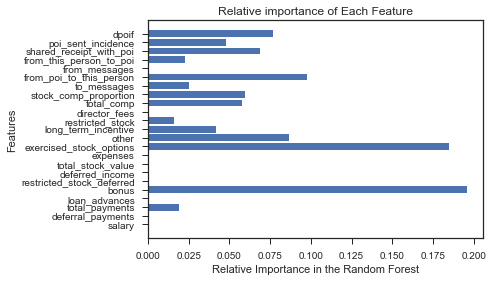

Accuracy: 0.83820
Precision: 0.33740        
Recall: 0.22150
F1: 0.26743
F2: 0.23784

Total predictions: 15000
True positives:  443
False positives:  870        
False negatives: 1557
True negatives: 12130



,description,accuracy,precision,recall,f1,f2
0,NB: KBest,0.853000,0.433138,0.3320,0.375885,0.348264
1,"NB: MinMax, KBest",0.844000,0.391304,0.3060,0.343434,0.319950
2,NB: PCA -> KBest,0.831733,0.364249,0.3515,0.357761,0.353978
3,NB: RFECV,0.677467,0.241718,0.6640,0.354417,0.492071
4,"SVM: MinMax, KBest",0.842733,0.354656,0.2190,0.270788,0.237141
5,"SVM: MinMax, RFECV",0.824600,0.286391,0.2115,0.243313,0.223172
6,"SVM: MinMax, PCA",0.832467,0.346683,0.2900,0.315818,0.299804
7,SVM: 'Piecewise' PCA,0.881000,0.839117,0.1330,0.229607,0.159913
8,"SVM: 'Piecewise' PCA, Class Weight",0.749467,0.309575,0.7145,0.431983,0.566344
9,"DT: MinMax, KBest",0.822667,0.302632,0.2530,0.275599,0.261580


In [30]:
### Data, features import
feature_list = poi_label + financial_features + ['total_comp', 'stock_comp_proportion'] + email_features + ['poi_sent_incidence', 'dpoif'] 

### Do split(s) [and training] on data set
data = featureFormat(my_dataset, feature_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
cv = StratifiedShuffleSplit(labels_rus, 20, random_state = 42)

## Set up pipeline
pipe = Pipeline([('rfc', RandomForestClassifier())])

### Optimize parameters
params = {'rfc__n_estimators': range(1, 20),
          'rfc__max_features': ['auto', 'log2', None]}

grid_search = GridSearchCV(pipe, cv = cv, param_grid = params, scoring = 'f1', verbose = 1, n_jobs = 3)
gs_fit = grid_search.fit(features, labels)
print "Best parameters:", gs_fit.best_params_
clf = gs_fit.best_estimator_
feature_importances = clf.named_steps['rfc'].feature_importances_
feature_importances_dict = dict(zip(feature_list[1:], feature_importances))
print "Feature Importances:"
pp.pprint(feature_importances_dict)

### Plot feature importance
plt.barh(range(len(feature_list[1:])), feature_importances, align='center')
plt.yticks(range(len(feature_list[1:])), feature_list[1:])
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

### Run algorithm; evaluate performance
accuracy, precision, recall, f1, f2 = tester(clf, my_dataset, feature_list)
desc = "Random Forest: Custom Feature Selection"
perf_dict = dict(zip(cols, [desc, accuracy, precision, recall, f1, f2]))
perf_df = perf_df.append(perf_dict, ignore_index=True)
perf_df

I run the same Random Forest algorithm to attune the algorithm to the minority class (by tuning the `class_weight` parameter) in particular. 

Fitting 20 folds for each of 57 candidates, totalling 1140 fits


//anaconda/envs/DAND/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
//anaconda/envs/DAND/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
//anaconda/envs/DAND/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
[Parallel(n_jobs=3)]: Done 310 tasks      | elapsed:    3.8s
[Parallel(n_jobs=3)]: Done 1140 out of 1140 | elapsed:   14.6s finished


Best parameters: {'rfc__n_estimators': 1, 'rfc__max_features': 'auto'}
Feature Importances:
{'bonus': 0.016101160064915555,
 'deferral_payments': 0.0,
 'deferred_income': 0.0,
 'director_fees': 0.0,
 'dpoif': 0.0,
 'exercised_stock_options': 0.18103950588229378,
 'expenses': 0.0,
 'from_messages': 0.03205313383233462,
 'from_poi_to_this_person': 0.0,
 'from_this_person_to_poi': 0.10357933773903234,
 'loan_advances': 0.0,
 'long_term_incentive': 0.026201887807502208,
 'other': 0.0,
 'poi_sent_incidence': 0.16585177456908792,
 'restricted_stock': 0.0,
 'restricted_stock_deferred': 0.0,
 'salary': 0.08322463041027751,
 'shared_receipt_with_poi': 0.33971711199431626,
 'stock_comp_proportion': 0.0,
 'to_messages': 0.0,
 'total_comp': 0.0,
 'total_payments': 0.05223145770023978,
 'total_stock_value': 0.0}


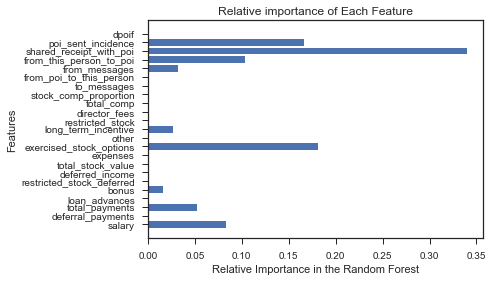

Accuracy: 0.82313
Precision: 0.31770        
Recall: 0.28450
F1: 0.30018
F2: 0.29057

Total predictions: 15000
True positives:  569
False positives: 1222        
False negatives: 1431
True negatives: 11778



,description,accuracy,precision,recall,f1,f2
0,NB: KBest,0.853000,0.433138,0.3320,0.375885,0.348264
1,"NB: MinMax, KBest",0.844000,0.391304,0.3060,0.343434,0.319950
2,NB: PCA -> KBest,0.831733,0.364249,0.3515,0.357761,0.353978
3,NB: RFECV,0.677467,0.241718,0.6640,0.354417,0.492071
4,"SVM: MinMax, KBest",0.842733,0.354656,0.2190,0.270788,0.237141
5,"SVM: MinMax, RFECV",0.824600,0.286391,0.2115,0.243313,0.223172
6,"SVM: MinMax, PCA",0.832467,0.346683,0.2900,0.315818,0.299804
7,SVM: 'Piecewise' PCA,0.881000,0.839117,0.1330,0.229607,0.159913
8,"SVM: 'Piecewise' PCA, Class Weight",0.749467,0.309575,0.7145,0.431983,0.566344
9,"DT: MinMax, KBest",0.822667,0.302632,0.2530,0.275599,0.261580


In [31]:
### Data, features import
feature_list = poi_label + financial_features + ['total_comp', 'stock_comp_proportion'] + email_features + ['poi_sent_incidence', 'dpoif']

### Do split(s) [and training] on data set
data = featureFormat(my_dataset, feature_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
cv = StratifiedShuffleSplit(labels_rus, 20, random_state = 42)

## Set up pipeline
pipe = Pipeline([('rfc', RandomForestClassifier(class_weight = 'balanced'))])

### Optimize parameters
params = {'rfc__n_estimators': range(1, 20),
          'rfc__max_features': ['auto', 'log2', None]}

grid_search = GridSearchCV(pipe, cv = cv, param_grid = params, scoring = 'f1', verbose = 1, n_jobs = 3)
gs_fit = grid_search.fit(features, labels)
print "Best parameters:", gs_fit.best_params_
clf = gs_fit.best_estimator_
feature_importances = clf.named_steps['rfc'].feature_importances_
feature_importances_dict = dict(zip(feature_list[1:], feature_importances))
print "Feature Importances:"
pp.pprint(feature_importances_dict)

### Plot feature importance
plt.barh(range(len(feature_list[1:])), feature_importances, align='center')
plt.yticks(range(len(feature_list[1:])), feature_list[1:])
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

### Run algorithm; evaluate performance
accuracy, precision, recall, f1, f2 = tester(clf, my_dataset, feature_list)
desc = "Random Forest: Class Weight"
perf_dict = dict(zip(cols, [desc, accuracy, precision, recall, f1, f2]))
perf_df = perf_df.append(perf_dict, ignore_index=True)
perf_df

# Question 3

_What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?_

Below is a table of the various approaches attempted, ranked by F1 score as the primary index.

**In `poi_id.py`, I chose to implement the top ranked algorithm among these implementations.**

In [32]:
perf_df.sort_values(['f1', 'recall', 'accuracy'], ascending=False)

,description,accuracy,precision,recall,f1,f2
11,"DT: Custom Feature Selection, Criterion",0.852643,0.487231,0.6010,0.538169,0.574186
8,"SVM: 'Piecewise' PCA, Class Weight",0.749467,0.309575,0.7145,0.431983,0.566344
10,"DT: MinMax, KBest, Criterion, Class Weight",0.786000,0.325749,0.5655,0.413377,0.492939
0,NB: KBest,0.853000,0.433138,0.3320,0.375885,0.348264
2,NB: PCA -> KBest,0.831733,0.364249,0.3515,0.357761,0.353978
3,NB: RFECV,0.677467,0.241718,0.6640,0.354417,0.492071
1,"NB: MinMax, KBest",0.844000,0.391304,0.3060,0.343434,0.319950
6,"SVM: MinMax, PCA",0.832467,0.346683,0.2900,0.315818,0.299804
16,Random Forest: Class Weight,0.823133,0.317700,0.2845,0.300185,0.290573
9,"DT: MinMax, KBest",0.822667,0.302632,0.2530,0.275599,0.261580


# Question 6

_Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance._

For the selected algorithm (Decision Tree), the results can be interpreted the following ways:

- The *accuracy* of the algorithm describes the proportion of correct classifications overall. For my decision tree this was $85\%$, which means that it is correct about $85\%$ of the time.

    - Mathematically, accuracy can be expressed as: 

$$\text{accuracy} = \frac{\text{True POIs} + \text{True Non-POIs}}{\text{All Predictions}}$$

- The *precision* of the algorithm is a measure of how often a prediction is correct _given the prediction identifies a POI_. For my model, it was correct about $48\%$ of the time it identified a given subject as a POI.
    - Mathematically, precision can be expressed as: 

$$\text{precision} = \frac{\text{True POIs}}{\text{True POIs} + \text{False POIs}}$$

- The *recall* of the algorithm is a measure of how often a prediction is correct _given the subject predicted is actually a POI_. For my model, it was correct in identifying $60\%$ of POIs as POIs.
    - Mathematically, recall can be expressed as: 

$$\text{recall} = \frac{\text{True POIs}}{\text{True POIs} + \text{False Non-POIs}}$$

- The *F1 score* of the algorithm is simply the harmonic average of the recall and precision. Basically, it is an average that is less susceptible to showing a good score if the two intermediary measures are wildly imbalanced (e.g., precision is quite high and recall quite low).


# Question 5

_What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?_

I employed _stratified shuffle split_ cross-validation in the training and testing of the algorithms enclosed herein. This means that the data set was split into a testing and training set (10%:90% by default), but the assignment of specific indexes to each set preserved the proportion of samples in each class (i.e., POI or non-POI). 

These _stratified randomizations_ were done multiple times (20+ times, exact number dependent on run-time considerations for specific choices of algorithm). Performance for each iteration (or fold) was recorded, and the average was reported. For the table above, the testing function (provided) reflects the average performance over 15000 folds.

The point of this is to avoid data leakage, or exposing the model during training to data used in testing. This is critical to prevent since algorithms are susceptible to simply "memorizing" certain data which reduces the generalizability of its use for data it has not seen before (e.g., doing prediction for new data).